In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import numpy
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [117]:

train = pd.read_csv('../train.csv',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
test = pd.read_csv('../test.csv',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
# train = normailize_df(train, True)
# test = normailize_df(test, False)
train.drop(columns=["direccion", 'lat', 'lng', 'idzona'], inplace=True)
test.drop(columns=["direccion", 'lat', 'lng', 'idzona'], inplace=True)
train = train[~train.tipodepropiedad.isnull()]
df_all = train.append(test)
test[test.tipodepropiedad.isnull()]

,id,titulo,descripcion,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos
13702,177475,casas en condominio - av. jesús del monte,"bonita casa en condominio de 29 casas, de espa...",NaN,NaN,Distrito Federal,NaN,NaN,NaN,NaN,NaN,244.0,2015-07-03,0,0,0,0,0
15832,283008,comercio - revillagigedo,"excelente local totalmente remodelado, con mag...",NaN,Cuauhtémoc,Distrito Federal,65.0,NaN,NaN,NaN,NaN,50.0,2015-07-03,0,0,0,0,0
26720,31177,locales en venta balcones del valle,oficinas pb: local 35m2 que actualmente esta r...,NaN,San Luis Potosí,San luis Potosí,17.0,NaN,NaN,NaN,100.0,40.0,2014-11-02,0,0,0,0,0
38993,290726,casas de campo en venta fracc real del potosi,"casa de campo, 3 recamaras, 2 baã?â??os, sala,...",NaN,San Luis Potosí,San luis Potosí,NaN,3.0,NaN,2.0,300.0,NaN,2014-08-24,0,0,0,0,0
46981,288517,casas en venta villas merlot,"excelente casa, en zona de casas muy bonitas",NaN,NaN,San luis Potosí,NaN,3.0,NaN,3.0,112.0,90.0,2014-06-24,0,0,0,0,0
47296,274853,"exclusiva residencia en sodzil nte, en venta",<p>estrena y forme parte de esta novedosa resi...,NaN,Mérida,Yucatán,NaN,3.0,2.0,4.0,165.0,245.0,2015-11-06,0,0,0,0,0
50869,22332,casas en venta horizontes residencial,lotes 92 y 166 **casa dos plantas 3 recama...,NaN,San Luis Potosí,San luis Potosí,NaN,3.0,NaN,NaN,117.0,161.0,2014-06-22,0,0,0,0,0


In [118]:
# df_all[:train] = np.log(df_train.SalePrice)
df_all['preciomt2'] = df_all['precio'] / (df_all['metroscubiertos'] + df_all['metrostotales'])
df_all['logpreciomt2'] = np.log1p(df_all.preciomt2)
df_all['logprecio'] = np.log1p(df_all.precio)

corr = df_all.corr().abs()
corr.precio[corr.precio >= 0.5].sort_values(ascending=False)

precio             1.000000
logprecio          0.898767
logpreciomt2       0.710653
preciomt2          0.684232
metroscubiertos    0.629207
banos              0.534096
metrostotales      0.514441
Name: precio, dtype: float64

In [119]:
def null_values(df):
    
    sum_null = df.isnull().sum()
    total = df.isnull().count()
    percent_nullvalues = 100* sum_null / total 
    df_null = pd.DataFrame()
    df_null['Total'] = total
    df_null['Null_Count'] = sum_null
    df_null['Percent'] = round(percent_nullvalues,2)
    df_null = df_null.sort_values(by='Null_Count',ascending = False)
    df_null = df_null[df_null.Null_Count > 0]
    
    return(df_null)
null_values(train)

,Total,Null_Count,Percent
metrostotales,239954,51458,21.44
antiguedad,239954,43519,18.14
garages,239954,37734,15.73
banos,239954,26191,10.92
habitaciones,239954,22453,9.36
metroscubiertos,239954,17386,7.25
titulo,239954,5387,2.25
descripcion,239954,1615,0.67
ciudad,239954,354,0.15
provincia,239954,153,0.06


In [120]:
null_values(train[train['metrostotales'].isnull()])

,Total,Null_Count,Percent
metrostotales,51458,51458,100.00
garages,51458,10084,19.60
antiguedad,51458,9348,18.17
banos,51458,5086,9.88
habitaciones,51458,4338,8.43
titulo,51458,1619,3.15
descripcion,51458,431,0.84
ciudad,51458,97,0.19
provincia,51458,46,0.09


In [121]:
null_values(train[(train['metroscubiertos'].isnull())])
#los que no tienen metros cubiertos mayormente tampoco tienen baños declarados. Podemos asumir
#si no hay metros cubiertos entonces --> no hay banos 
# train[train['metroscubiertos'].isnull()].tipodepropiedad.value_counts()

,Total,Null_Count,Percent
metroscubiertos,17386,17386,100.00
banos,17386,10784,62.03
habitaciones,17386,9645,55.48
antiguedad,17386,6000,34.51
garages,17386,5870,33.76
titulo,17386,439,2.53
descripcion,17386,179,1.03
ciudad,17386,45,0.26
provincia,17386,26,0.15


In [122]:
# Analisemos cuidadosamente los terrenos primero
null_values(train[(train['metroscubiertos'].isnull()) & (train['tipodepropiedad'] == 'Terreno')])

,Total,Null_Count,Percent
metroscubiertos,6940,6940,100.00
habitaciones,6940,6910,99.57
banos,6940,6904,99.48
antiguedad,6940,3591,51.74
garages,6940,1942,27.98
titulo,6940,107,1.54
descripcion,6940,55,0.79
ciudad,6940,5,0.07
provincia,6940,1,0.01


In [123]:
corr = df_all[df_all['tipodepropiedad'] == 'Terreno'].corr()
corr['precio']

antiguedad                    0.240909
banos                         0.377645
centroscomercialescercanos    0.079141
escuelascercanas              0.055117
garages                       0.076076
gimnasio                      0.006184
habitaciones                  0.207781
id                           -0.012915
metroscubiertos               0.203114
metrostotales                 0.248595
piscina                      -0.033881
precio                        1.000000
usosmultiples                      NaN
preciomt2                     0.788426
logpreciomt2                  0.798672
logprecio                     0.887038
Name: precio, dtype: float64

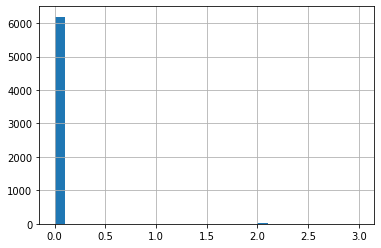

In [124]:
condition = (df_all['metroscubiertos'].isnull()) & (df_all['tipodepropiedad'] == 'Terreno')
df_all.loc[condition, 'garages'].hist(bins=30)

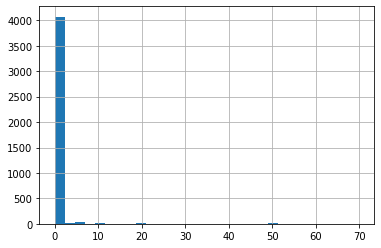

In [125]:
condition = (df_all['metroscubiertos'].isnull()) & (df_all['tipodepropiedad'] == 'Terreno')
df_all.loc[condition, 'antiguedad'].hist(bins=30)

In [126]:
# Vemos que los que tienen valores nulos en metros cubiertos tambien tienen banos, habitaciones, garages y antiguedad. Consideramos todos estos 
# como 0 entonces.
condition = (df_all['metroscubiertos'].isnull()) & (df_all['tipodepropiedad'] == 'Terreno')
df_all.loc[condition, 'banos'] = 0
df_all.loc[condition, 'habitaciones'] = 0
df_all.loc[condition, 'metroscubiertos'] = 0
df_all.loc[condition, 'garages'] = 0
df_all.loc[condition, 'antiguedad'] = 0

In [127]:
condition = (df_all['metrostotales'].isnull()) & (df_all['tipodepropiedad'] == 'Terreno')

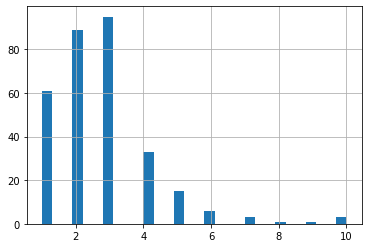

In [128]:
# En este caso vemos que hay distribucion en las antiguedades distinta de 0. Esto podria tenerlo en cuenta 
# el algoritmo que usemos. Por lo que solo llenaremos los NULOS con 0 y no todos.
df_all[condition].habitaciones.hist(bins=30)

In [129]:
#normalizemos solo los nulos
condition = (df_all['metrostotales'].isnull()) & (df_all['tipodepropiedad'] == 'Terreno')

for col in ['antiguedad', 'habitaciones', 'banos', 'garages', 'metrostotales', 'gimnasio']:
    df_all.loc[condition, col] = df_all[condition][col].fillna(0)
    

In [130]:
corr = df_all[df_all['tipodepropiedad'] == 'Terreno'].corr()
corr['precio']

antiguedad                    0.138833
banos                         0.245324
centroscomercialescercanos    0.079141
escuelascercanas              0.055117
garages                       0.075389
gimnasio                      0.006184
habitaciones                  0.199111
id                           -0.012915
metroscubiertos               0.325960
metrostotales                -0.031856
piscina                      -0.033881
precio                        1.000000
usosmultiples                      NaN
preciomt2                     0.788426
logpreciomt2                  0.798672
logprecio                     0.887038
Name: precio, dtype: float64

In [131]:
df_all[df_all.metrostotales.isnull()].tipodepropiedad.value_counts()

Apartamento                      34911
Casa                             20712
Casa en condominio                2663
Local Comercial                   1083
Oficina comercial                  941
Quinta Vacacional                  431
Bodega comercial                   353
Terreno comercial                  329
Villa                              267
Rancho                             190
Edificio                           178
Casa uso de suelo                  136
Inmuebles productivos urbanos       60
Local en centro comercial           59
Departamento Compartido             57
Otros                               39
Nave industrial                     37
Duplex                              36
Huerta                              23
Terreno industrial                  18
Hospedaje                            1
Garage                               1
Name: tipodepropiedad, dtype: int64

In [132]:
#Veamos ahora apartamentos que tengan completado metrostotales y metroscubiertos. 80% poseen el mismo valor en ambos.
notnull = (df_all['tipodepropiedad'] == 'Apartamento') & (~df_all['metrostotales'].isnull()) & (~df_all['metroscubiertos'].isnull())
desigualmt2notnull = (df_all['tipodepropiedad'] == 'Apartamento') & (df_all['metrostotales'] != df_all['metroscubiertos']) & (~df_all['metrostotales'].isnull()) & (~df_all['metroscubiertos'].isnull())
igualmt2notnull = (df_all['tipodepropiedad'] == 'Apartamento') & (df_all['metrostotales'] == df_all['metroscubiertos']) & (~df_all['metrostotales'].isnull()) & (~df_all['metroscubiertos'].isnull())
null = (df_all['tipodepropiedad'] == 'Apartamento') & (df_all['metrostotales'].isnull() | df_all['metroscubiertos'].isnull())

# import pandas.rpy.common as com
import seaborn as sns


# load the R package ISLR
# infert = com.importr("ISLR")

# load the Auto dataset
# auto_df = com.load_data('Auto')

# calculate the correlation matrix
corr = df_all[df_all['tipodepropiedad'] == 'Apartamento'].corr()
corr['precio']
# plot the heatmap
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu")
# df_all[desigualmt2notnull].shape[0] / df_all[notnull].shape[0]

antiguedad                   -0.184229
banos                         0.639579
centroscomercialescercanos    0.002865
escuelascercanas             -0.031904
garages                       0.544253
gimnasio                      0.290344
habitaciones                  0.291613
id                           -0.001523
metroscubiertos               0.751721
metrostotales                 0.733999
piscina                       0.242222
precio                        1.000000
usosmultiples                 0.206428
preciomt2                     0.715632
logpreciomt2                  0.701497
logprecio                     0.902800
Name: precio, dtype: float64

In [133]:
#Veamos ahora apartamentos que tengan completado metrostotales y metroscubiertos.
corr2 = df_all[igualmt2notnull].corr()
(corr - corr2) > 0
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu")
# df_all[igualmt2notnull].shape[0] / df_all[notnull].shape[0]

,antiguedad,banos,centroscomercialescercanos,escuelascercanas,garages,gimnasio,habitaciones,id,metroscubiertos,metrostotales,piscina,precio,usosmultiples,preciomt2,logpreciomt2,logprecio
antiguedad,False,True,True,True,True,True,False,False,False,False,True,False,True,True,True,False
banos,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
centroscomercialescercanos,True,False,False,False,False,True,False,False,False,False,True,False,True,True,True,False
escuelascercanas,True,False,False,False,False,True,False,False,False,False,True,False,True,True,True,False
garages,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
gimnasio,True,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False
habitaciones,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,False
id,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
metroscubiertos,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
metrostotales,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [134]:
df_all[df_all.tipodepropiedad == 'Casa'].isnull().sum()

antiguedad                    28346
banos                         10718
centroscomercialescercanos        0
ciudad                          295
descripcion                    1244
escuelascercanas                  0
fecha                             0
garages                       29878
gimnasio                          0
habitaciones                   4192
id                                0
metroscubiertos                8162
metrostotales                 20712
piscina                           0
precio                        35415
provincia                       127
tipodepropiedad                   0
titulo                         3996
usosmultiples                     0
preciomt2                     58603
logpreciomt2                  58603
logprecio                     35415
dtype: int64

In [135]:
null_values(df_all[(df_all.tipodepropiedad == 'Casa')])

,Total,Null_Count,Percent
logpreciomt2,177132,58603,33.08
preciomt2,177132,58603,33.08
logprecio,177132,35415,19.99
precio,177132,35415,19.99
garages,177132,29878,16.87
antiguedad,177132,28346,16.00
metrostotales,177132,20712,11.69
banos,177132,10718,6.05
metroscubiertos,177132,8162,4.61
habitaciones,177132,4192,2.37


In [136]:
def resolverCampo(tipodepropiedad, campo, test):
    pred_train = df_all[(df_all.tipodepropiedad == tipodepropiedad) & (~df_all[campo].isnull())] 
    pred_test = df_all[(df_all.tipodepropiedad == tipodepropiedad) & (df_all[campo].isnull())]

    every_column_except_y= [col for col in pred_train.columns if col not in [campo, 'id', 'ciudad', 'fecha', 'provincia', 'tipodepropiedad', 'precio', 'descripcion', 'titulo']]
    
    if(pred_train[every_column_except_y].shape[0] <= 1): return 0
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 5, alpha = 10, n_estimators = 400, n_jobs=40)
    
    if(test): 
        X_train, X_test, y_train, y_test = train_test_split(pred_train[every_column_except_y], pred_train[campo], test_size=0.2, random_state=123)
        xg_reg.fit(X_train,y_train)
        pred= xg_reg.predict(X_test)     
        return np.sqrt(mean_squared_error(y_test, pred))
    else:    
        xg_reg.fit(pred_train[every_column_except_y],pred_train[campo])
        pred= xg_reg.predict(pred_test[every_column_except_y])
        return pred

In [137]:
df_all['metrostotales'] = np.log1p(df_all['metrostotales'])
df_all['metroscubiertos'] = np.log1p(df_all['metroscubiertos'])
for el in ['Apartamento','Casa', 'Casa en condominio', 'Local Comercial', 'Oficina comercial', 'Quinta Vacacional', 'Bodega comercial', 'Terreno comercial', 'Villa', 'Rancho', 'Edificio', 'Casa uso de suelo', 'Inmuebles productivos urbanos', 'Local en centro comercial', 'Departamento Compartido', 'Otros', 'Nave industrial', 'Duplex', 'Huerta', 'Terreno industrial', 'Garage', 'Hospedaje']:
    mtcubant = df_all.loc[(df_all.tipodepropiedad == el)].corr()['precio']['metroscubiertos']
    mtcubtot = df_all.loc[(df_all.tipodepropiedad == el)].corr()['precio']['metrostotales']
    
    df_all.loc[(df_all.tipodepropiedad == el) & (df_all['metroscubiertos'].isnull()), 'metroscubiertos'] = resolverCampo(el, 'metroscubiertos', False)
    df_all.loc[(df_all.tipodepropiedad == el) & (df_all['metrostotales'].isnull()), 'metrostotales'] = resolverCampo(el, 'metrostotales', False)
    mtcubdes = df_all.loc[(df_all.tipodepropiedad == el)].corr()['precio']['metroscubiertos']
    mtcubdestot = df_all.loc[(df_all.tipodepropiedad == el)].corr()['precio']['metrostotales']

df_all['metrostotales'] = np.expm1(df_all['metrostotales'])
df_all['metroscubiertos'] = np.expm1(df_all['metroscubiertos'])
df_all.tipodepropiedad
    
    

0               Apartamento
1        Casa en condominio
2                      Casa
3                      Casa
4               Apartamento
                ...        
59995                  Casa
59996                  Casa
59997                  Casa
59998                  Casa
59999                  Casa
Name: tipodepropiedad, Length: 299954, dtype: object

In [138]:
df_all.loc[:, 'banos'] = df_all['banos'].fillna(0)
df_all.loc[:, 'habitaciones'] = df_all['habitaciones'].fillna(0)
df_all.loc[:, 'metroscubiertos'] = df_all['metroscubiertos'].fillna(0)
df_all.loc[:, 'garages'] = df_all['garages'].fillna(0)
df_all.loc[:, 'metrostotales'] = df_all['metrostotales'].fillna(0)

In [139]:
null_values(df_all)

,Total,Null_Count,Percent
logpreciomt2,299954,128844,42.95
preciomt2,299954,128844,42.95
logprecio,299954,60000,20.00
precio,299954,60000,20.00
antiguedad,299954,48449,16.15
titulo,299954,6765,2.26
descripcion,299954,2016,0.67
ciudad,299954,437,0.15
provincia,299954,195,0.07
tipodepropiedad,299954,7,0.00


In [140]:

import category_encoders as ce
#Labeling

cols = ['tipodepropiedad', 'provincia', 'ciudad'] 
         #, 'provincia', 'ciudad'
        
encoder = ce.BinaryEncoder(cols=cols)
df_all = encoder.fit_transform(df_all)

In [141]:
# df_all[:train] = np.log(df_train.SalePrice)
df_all['metros'] = np.abs(df_all['metroscubiertos'] + df_all['metrostotales'])
df_all['preciomt2'] = df_all['precio'] / (df_all['metroscubiertos'] + df_all['metrostotales'])
df_all['logpreciomt2'] = np.log1p(df_all.preciomt2)

corr = df_all.corr().abs()
corr.precio[corr.precio >= 0.5].sort_values(ascending=False)

precio             1.000000
logprecio          0.898767
logpreciomt2       0.690921
metros             0.654460
metroscubiertos    0.649994
metrostotales      0.542373
preciomt2          0.538072
Name: precio, dtype: float64

In [142]:
from numpy.random import seed
from numpy.random import randn
from numpy import percentile
#
# calculate interquartile range
q25, q75 = percentile(df_all[:train.shape[0]].logpreciomt2, 25), percentile(df_all[:train.shape[0]].logpreciomt2, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
train = df_all[:train.shape[0]] 
test = df_all[train.shape[0]:] 
train = train[~((train.logpreciomt2 < lower) | (train.logpreciomt2 > upper) & (train.logpreciomt2 != 0))]
df_all = train.append(test)


# train.shape
# outliers = [x for x in df_all[:train.shape[0]].logpreciomt2 if x < lower or x > upper]
# print('Identified outliers: %d' % len(outliers))
# outliers
# outliers_removed = [x for x in data if x >= lower and x <= upper]
# print('Non-outlier observations: %d' % len(outliers_removed))


Percentiles: 25th=8.304, 75th=9.075, IQR=0.771


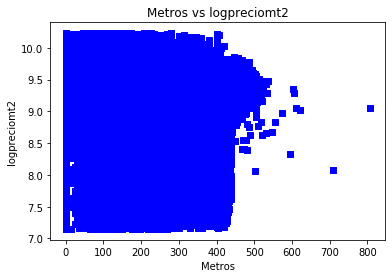

In [143]:
plt.scatter(train.metroscubiertos, train.logpreciomt2, c = "blue", marker = "s")
plt.title("Metros vs logpreciomt2")
plt.xlabel("Metros")
plt.ylabel("logpreciomt2")
plt.show()

In [144]:
from scipy.stats import skew

#log transform skewed numeric features:
numeric_feats = df_all.dtypes[(df_all.dtypes == "float64") | (df_all.dtypes == "int64")].index
skewed_feats = df_all[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = [col for col in skewed_feats.index if col not in ['id', 'precio', 'preciomt2']] 

In [145]:
# final = test[['id']]
# final.loc[:, 'target'] = np.expm1(pred)
train.set_index('id').to_csv('../normalized_train.csv')
test.set_index('id').to_csv('../normalized_test.csv')
